Note: The code here is exemplary, all relevant data files are in the raw_data folder. For finalized data see the folder processed_data.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.tsa.stattools import adfuller
from scipy.cluster import hierarchy
from statsmodels.formula.api import ols
import statsmodels.api as sm

In [21]:
from pathlib import Path

# Get the root directory of the current project
project_dir = Path().resolve()

# Define the path to the raw data folder relative to the project directory
data_dir = project_dir / 'data_files' / 'raw_data'

# List of themes and corresponding file names
themes = {
    'gdp': 'gdp_transformed.csv',
    'employment': 'employment_transformed.csv',
    'trade': 'trade_transformed.csv',
    'finance': 'finance_transformed.csv',
    'money': 'money_transformed.csv',
    'industry': 'industry_transformed.csv',
    'other': 'other_transformed.csv',
    'price': 'price_transformed.csv',
    'exchangerate': 'exchangerate_transformed.csv'
}

# Loop to read all the CSV files and create variables for each theme
for theme, file_name in themes.items():
    file_path = data_dir / file_name  # Use Path object to join paths
    globals()[theme] = pd.read_csv(file_path, 
                                   parse_dates=['Date'],
                                   date_format='%m/%d/%y',
                                   index_col='Date')

# Now you can directly access each dataframe using the theme name, e.g., gdp, employment, trade, etc.


In [22]:

panels = [gdp, employment, trade, finance, money, industry, other, price, exchangerate]
# Initially resample to daily frequency
for panel in panels:
    panel = panel.resample('D').asfreq()


Create meta csv with all the variable names and frequency

Note: meta is created before hand so here is an example how you could create a meta file. Suppose you download the data with the first row showing the frequency of the series from wind. Block structure is created manually up to the design (for each block, the header would be the name of the factor and entris would be 0 if the series is not in the block and 1 if the series is in the block). The finalized meta data is provided in the processed_data folder. Here are example codes for automatically creating block structure. Adjust the details according to the specific design. The actual meta data used in the project is in the folder processed_data.

import pandas as pd
import numpy as np

meta_data = []

for panel in panels:
    series = panel.columns.tolist()  # column names contain variable names
    freq = panel.iloc[0].tolist()    # first row contains frequencies
    
    for s, f in zip(series, freq):
        meta_data.append({'series': s, 'freq': f})

meta_df = pd.DataFrame(meta_data)

meta_df = meta_df.drop_duplicates()

print(meta_df.head())

# Save the metadata DataFrame in the parallel directory 'raw_data'
meta_df.to_csv(project_dir / 'data_files' / 'raw_data' / 'meta_data.csv', index=False)

# Create block structure automatically

# Load the meta data
meta_df = pd.read_csv(project_dir / 'data_files' / 'raw_data' / 'meta_data.csv')

# Define the blocks and their corresponding series
blocks = {
    'GDP': ['China: GDP: Quarterly: YoY Growth', 'China: GDP: Cumulative YTD: YoY Growth'],
    'Employment': ['China: Unemployment Rate: Urban Survey', 'China: Employment: New Jobs Created in Urban Areas: Cumulative'],
    'Trade': ['China: Total Retail Sales of Consumer Goods:PoP GROWTHRATE', 'China: Value of Imports and Exports:PoP GROWTHRATE'],
    'Finance': ['China: Shanghai Stock Exchange: Composite Index', 'China: Shenzhen Stock Exchange: Component Index'],
    'Money': ['China: M2: YoY Growth', 'China: M1: YoY Growth'],
    'Industry': ['China: Industrial Production: YoY Growth', 'China: Purchasing Managers Index (PMI)'],
    'Price': ['China: Consumer Price Index (CPI): YoY Growth', 'China: Producer Price Index (PPI): YoY Growth'],
    'Exchange Rate': ['China: Exchange Rate: USD/CNY', 'China: Exchange Rate: EUR/CNY']
}

# Create the block structure
block_structure = pd.DataFrame(index=meta_df['series'], columns=blocks.keys())

for block, series_list in blocks.items():
    block_structure[block] = np.where(block_structure.index.isin(series_list), 1, 0)

# Fill NaN values with 0
block_structure = block_structure.fillna(0)

# Save the block structure
block_structure.to_csv(project_dir / 'data_files' / 'raw_data' / 'block_structure.csv')

print(block_structure)

create combined panel

In [26]:
import pandas as pd
from functools import reduce

def prepare_df(df):
    if 'Date' in df.columns:
        df = df.set_index('Date')
    df.index.name = 'Date'
    return df

# Prepare all DataFrames
panels = [prepare_df(df) for df in panels]

# Function to merge DataFrames
def merge_dfs(left, right):
    return pd.merge(left, right, left_index=True, right_index=True, how='outer')

# Merge all DataFrames
combined = reduce(merge_dfs, panels)

print(combined.info())
combined.to_csv(project_dir / 'data_files' / 'raw_data' / 'combined_transformed.csv')

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13295 entries, 1969-12-31 to 2068-12-31
Data columns (total 84 columns):
 #   Column                                                                                                                  Non-Null Count  Dtype  
---  ------                                                                                                                  --------------  -----  
 0   China: GDP: Current Prices:PoP GROWTHRATE                                                                               129 non-null    float64
 1   Surveyed Urban Unemployment Rate in 31 Big Cities and Towns:PoP chg                                                     78 non-null     float64
 2   China: Urban Surveyed Unemployed Rate: Mean:PoP chg                                                                     11 non-null     float64
 3   China: No. of New Employed Persons in Urban Areas: YTD:PoP GROWTHRATE                                                   137 

Adjust time frame to exclude years without gdp measures

In [ ]:
start_date = pd.to_datetime('02/01/1992', format='%m/%d/%Y')
end_date = pd.to_datetime('07/18/2024', format='%m/%d/%Y')

combined_filtered = combined.loc[(combined.index >= start_date) & (combined.index <= end_date)]

from datetime import datetime

# Convert the index to the desired format and save to csv
combined_filtered.index = combined_filtered.index.strftime('%Y/%m/%d')

combined_filtered = combined_filtered.reset_index().rename(columns={'index': 'Date'})

# Print a few rows to verify the conversion
print(combined_filtered.head())


Delete erratic first non-missing entries

(Original data file: monthly_stationary_notimputed)

Note: abnormal values in first non-missing entry due to differencing when pop value is not directly provided on wind. Need to manually check for abnormal first entries and set to nans for imputation. Here is the example code to delete first non-missing entry for series ending with 'chg' (indicating we obtained the difference mechanically, and the first non-missing entry is erratic)

In [36]:
import pandas as pd

# Drop the first non-missing value for series ending with 'chg'
for col in combined_filtered.columns:
    if col.endswith('chg'):
        # Find the index of the first non-missing value
        first_non_missing = combined_filtered[col].first_valid_index()
        if first_non_missing is not None:
            # Set the first non-missing value to NaN
            combined_filtered.loc[first_non_missing, col] = np.nan

combined_filtered.to_csv(project_dir / 'data_files' / 'raw_data' / 'period_adjusted.csv', index=False)

EM imputation for missing values at monthly frequency

In [ ]:
import numpy as np
import pandas as pd
import os

# Use combined_filtered instead of reading from a CSV file
data = combined_filtered.copy()

# Ensure the 'Date' column is set as the index and is in datetime format
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date').sort_index()

# Resample the data at monthly frequency, using average value
data = data.resample('M').mean()

# Adjust the index to the last day of each month
data.index = data.index + pd.offsets.MonthEnd(0)

# Print the first few rows to confirm the changes
print(data.head())

def fill_missing_em(data, ncomp, tol_em=1e-6, max_em_iter=1000):
    """
    EM algorithm to fill missing values in the dataset.

    Parameters:
        data (pd.DataFrame): The input data with missing values (NaNs).
        ncomp (int): The number of components (e.g., for PCA).
        tol_em (float): Tolerance for convergence.
        max_em_iter (int): Maximum number of iterations.

    Returns:
        pd.DataFrame: DataFrame with missing values filled.
    
    Raises:
        ValueError: If any column or row has fewer non-missing values than ncomp.
    """
    if not isinstance(data, pd.DataFrame):
        raise ValueError("Input data must be a pandas DataFrame")

    index = data.index
    column_names = data.columns
    data_array = data.to_numpy()

    non_missing = np.logical_not(np.isnan(data_array))

    # If nothing missing, return without altering the data
    if np.all(non_missing):
        return data

    # Ensure sufficient non-missing values
    col_non_missing = np.sum(non_missing, axis=0)
    row_non_missing = np.sum(non_missing, axis=1)
    if np.any(col_non_missing < ncomp) or np.any(row_non_missing < ncomp):
        raise ValueError('Implementation requires that all columns and '
                         'all rows have at least ncomp non-missing values')

    # Get mask of missing values
    mask = np.isnan(data_array)

    # Compute mean of non-missing values for each column
    mu = np.nanmean(data_array, axis=0)

    # Replace missing values with column means for initialization
    for i in range(data_array.shape[1]):
        data_array[mask[:, i], i] = mu[i]

    # Iterative EM algorithm
    diff = 1.0
    _iter = 0

    while diff > tol_em and _iter < max_em_iter:
        last_data = data_array.copy()

        # Perform SVD
        U, S, Vt = np.linalg.svd(data_array, full_matrices=False)

        # Reconstruct the data using the first `ncomp` components
        components = U[:, :ncomp] @ np.diag(S[:ncomp]) @ Vt[:ncomp, :]

        # Update the missing values
        data_array[mask] = components[mask]

        # Calculate convergence metric
        delta = data_array - last_data
        diff = np.linalg.norm(delta) / np.linalg.norm(data_array)
        _iter += 1

    # Convert back to DataFrame and restore index and column names
    filled_data = pd.DataFrame(data_array, index=index, columns=column_names)

    return filled_data

data = fill_missing_em(data, ncomp=1)
data = pd.DataFrame(data)

imputed = data.copy()


Mixed frequency imputation (keeping monthly/quarterly structure, only impute missing values at the start of the series)

In [ ]:
# Define the columns with quarterly frequency to maintain the missing value structure due to lower frequency
columns_to_modify = ['China: Current Employment Sentiment Index:PoP chg', 'China: Employment Expectation Index:PoP chg', 'China: Index of Future Price Expectation:PoP chg', 'China: Industrial Capacity Utilization:PoP chg', 'China: Industrial Added Value Above Designated Size: Manufacturing: YoY', 'China: Business Climate Index:PoP chg', 'China: Business Climate Index: Spot Index:PoP chg', 'China: GDP: Current Prices:PoP GROWTHRATE']

# Define the inter-quarter month to leave the quarterly variables as nans
months_to_modify = [1, 2, 4, 5, 7, 8, 10, 11]

# Set the values in the specified columns and months to nan
data.loc[data.index.month.isin(months_to_modify), columns_to_modify] = np.nan

print(data.head())

mq_imputed = data.copy()

            China: Financial Institutions: Total Deposits Balance: RMB:PoP GROWTHRATE  \
date                                                                                    
1992-02-29                                           0.050900                           
1992-03-31                                          -1.060169                           
1992-04-30                                           0.335426                           
1992-05-31                                          -0.472853                           
1992-06-30                                          -0.977048                           

            China: Industrial Added Value Above Designated Size: YoY  \
date                                                                   
1992-02-29                                                7.6          
1992-03-31                                               -1.7          
1992-04-30                                               -1.7          
1992-05-31      

Stationarity test and transformation

In [ ]:
# Non MQ stationary
data = imputed

from statsmodels.tsa.stattools import adfuller

# Function to perform ADF test
def adf_test(series, signif=0.05):
    """
    Perform ADF test and return True if the series is stationary
    """
    result = adfuller(series, autolag='AIC')
    p_value = result[1]
    return p_value < signif

# Apply ADF test to each series and collect non-stationary ones
non_stationary_series = []
data = data.copy()

for column in data.columns:
    series = data[column]
    if not adf_test(series):
        non_stationary_series.append(column)
        # Difference the series to make it stationary
        data[column] = series.diff().dropna()

# Report non-stationary series (for record purpose, understand that they are further differenced to impose stationarity)
print("Non-stationary series:")
for series in non_stationary_series:
    print(series)

data = data.dropna()

# Save as em in raw_files under the current project
#data.to_csv(project_dir / 'data_files' / 'raw_data' / 'em_stationary.csv', index=False)

Non-stationary series:
China: FAI: YTD:PoP GROWTHRATE
China: Total Retail Sales of Consumer Goods:PoP GROWTHRATE
China: Total Retail Sales of Consumer Goods: Catering Revenue:PoP GROWTHRATE
China: SHIBOR: O/N:PoP chg
China: Industrial Added Value Above Designated Size: Electric Power
China: Industrial Added Value Above Designated Size: Fixed-base Index:PoP GROWTHRATE
China: Industrial Added Value Above Designated Size: High-Tech Industry: YoY
China: Completed Investment in Real Estate Development: YTD:PoP GROWTHRATE
China: CPI: Excluding Food and Energy (Core CPI): MoM
China: CPI: Services: MoM


In [ ]:
#MQ stationary

data.loc[data.index.month.isin(months_to_modify), columns_to_modify] = np.nan

print(data.head())

# Save as em in raw_files under the current project
#data.to_csv(project_dir / 'data_files' / 'raw_data' / 'em_mq_stationary.csv', index=False)

            China: Financial Institutions: Total Deposits Balance: RMB:PoP GROWTHRATE  \
date                                                                                    
1992-03-31                                          -1.060169                           
1992-04-30                                           0.335426                           
1992-05-31                                          -0.472853                           
1992-06-30                                          -0.977048                           
1992-07-31                                           1.014801                           

            China: Industrial Added Value Above Designated Size: YoY  \
date                                                                   
1992-03-31                                               -1.7          
1992-04-30                                               -1.7          
1992-05-31                                               -0.8          
1992-06-30      

/var/folders/ns/hcbvd_hd3gxfr2y183d8csgr0000gn/T/ipykernel_51375/688643143.py:9: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  data['date'] = pd.to_datetime(data['date'], infer_datetime_format=True)


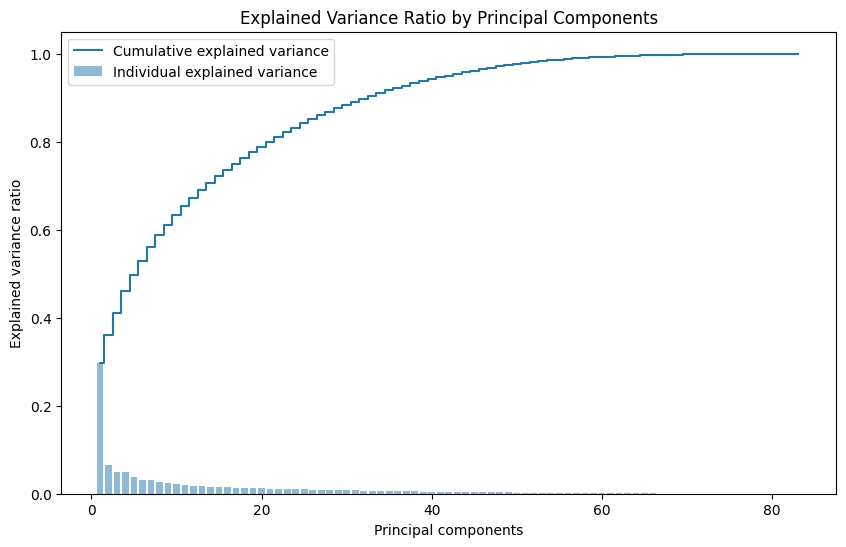

Number of components that explain at least 95% of the variance: 42
                                                         PC1       PC2  \
China: Financial Institutions: Total Deposits B... -0.072391 -0.043326   
China: Industrial Added Value Above Designated ... -0.034476 -0.126102   
China: FAI: YTD:PoP GROWTHRATE                     -0.083243 -0.029021   
Surveyed Urban Unemployment Rate in 31 Big Citi...  0.024600  0.082065   
China: Urban Surveyed Unemployed Rate: Mean:PoP...  0.195134 -0.063363   
...                                                      ...       ...   
China: Index of Future Price Expectation:PoP chg    0.107115  0.073534   
China: Industrial Capacity Utilization:PoP chg      0.194487 -0.017287   
China: Industrial Added Value Above Designated ...  0.040092  0.129746   
China: Business Climate Index:PoP chg               0.194022 -0.013685   
China: Business Climate Index: Spot Index:PoP chg   0.176383 -0.023920   

                                            

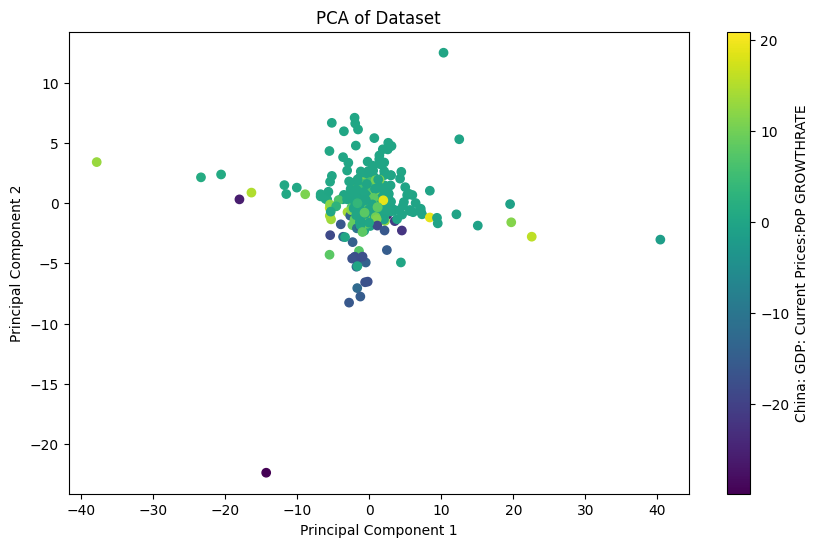

In [2]:
# Initial PCA analysis to examine the structure of the data
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Load the data
data = pd.read_csv('/Users/leyixu/Desktop/em_imputed_stationary.csv')
data['date'] = pd.to_datetime(data['date'], infer_datetime_format=True)
data.set_index('date', inplace=True)

# Define features and target
X = data.drop('China: GDP: Current Prices:PoP GROWTHRATE', axis=1)
y = data['China: GDP: Current Prices:PoP GROWTHRATE']

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Conduct PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Plot explained variance ratio
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, where='mid', label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.title('Explained Variance Ratio by Principal Components')
plt.legend(loc='best')
plt.show()

# Determine the number of components that explain at least 95% of the variance
n_components = np.argmax(cumulative_explained_variance >= 0.95) + 1
print(f'Number of components that explain at least 95% of the variance: {n_components}')

# Conduct PCA with the optimal number of components
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)

# Create a DataFrame for PCA results
pca_columns = [f'PC{i+1}' for i in range(X_pca.shape[1])]
X_pca_df = pd.DataFrame(X_pca, columns=pca_columns, index=data.index)

# Optional: Print PCA components (loadings)
loadings = pd.DataFrame(pca.components_.T, columns=pca_columns, index=X.columns)
print(loadings)

# Optional: Plot the first two principal components
plt.figure(figsize=(10, 6))
plt.scatter(X_pca_df['PC1'], X_pca_df['PC2'], c=y, cmap='viridis')
plt.colorbar(label='China: GDP: Current Prices:PoP GROWTHRATE')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Dataset')
plt.show()

Note: the PCA result is actually not used for selecting number of factors to include in dfm models because of the large number of factors selected can significantly slow down the optimization process. An alternative regularization method is used for feature selection.